In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
import os.path

Populating the interactive namespace from numpy and matplotlib


In [14]:
#first run is the baseline baseline
runs = [307936,307937,307938,307939]
vped = np.asarray([1106, 1156, 1206, 1256])

#channel being run on
asic=0
channel=7

#64 samples corresponding to 64 ns
times = np.arange(0,64,1)
baselines = []
shifts=[]

#going through each run
for j in range(len(runs)): 
    #loading the file
    infile="flasher_av_run"+str(runs[j])+"ASIC"+str(asic)+"CH"+str(channel)+".txt"
    print "load data"
    da = loadtxt(infile)
    #file is stored as:
    #asic, channel, block, shift, 64_samples
    print da.shape
    #print da[2,:]
    print "append data"
    #for each run, baseline has 512 blocks with 4 shifts each (2048), and 64 samples for each of those
    baseline = np.zeros((512,4,64))
    #starting with the 2nd line - the 1st contains column headers
    for i in range(1, da.shape[0]):
        #if(i==1): shifts.append(int(da[i,3]))
        #at the block and shift indices, add the samples data
        baseline[int(da[i,2]),int(da[i,3])/8] = (da[i,4:])
    baselines.append(baseline)
    
baselines = np.asarray(baselines)

load data
(2049, 68)
append data
load data
(2049, 68)
append data
load data
(2049, 68)
append data
load data
(2049, 68)
append data
(4, 512, 4, 64)


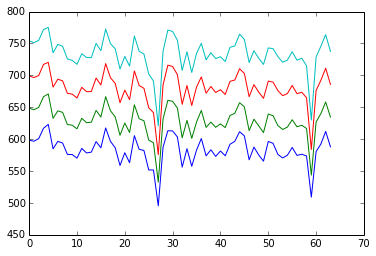

In [3]:
plot(times[:],baselines[0,200,0,:])
plot(times[:],baselines[1,200,0,:])
plot(times[:],baselines[2,200,0,:])
plot(times[:],baselines[3,200,0,:])


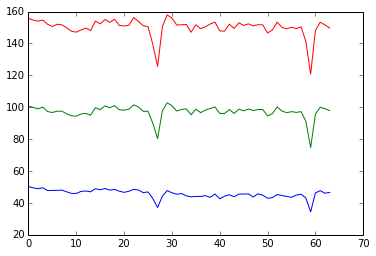

In [4]:
#run subtraction

#get the length of all the dimensions of data
nvpeds = len(vped)
nblocks = 512
nshifts = 4
nsamples = 64

#creating an array with those dimensions
subtractions = np.zeros((((nvpeds,nblocks,nshifts,nsamples))))

#nested for loop through each dimension
for i in range(nvpeds):
    for j in range(nblocks):
        for k in range(nshifts):
            for l in range(nsamples):
                #subtracting the main baseline data (1106 DAC counts) from each Vped
                #keep in mind that subtractions[0,:,:,:] will be filled with zeros
                #this is because the first index will be the main baseline subtracted from itself
                subtractions[i,j,k,l] = baselines[i][j,k,l] - baselines[0][j,k,l]
                
#print subtractions[1][200,0,:]

#plot (before correction) - baseline
plot(times[:],subtractions[1,200,0,:])
plot(times[:],subtractions[2,200,0,:])
plot(times[:],subtractions[3,200,0,:])

In [5]:
def calcSlope(y2, y1, x2, x1):
    return (y2 - y1)/(x2 - x1)

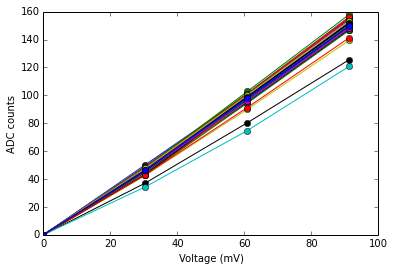

In [7]:
#linear correction

#converting Vped from DAC counts to mV
vpedV = (0.609)*vped + 26.25
vpedVsub = vpedV-vpedV[0]

#for each sample, record the slope going from the baseline vped to the next
slopes = np.zeros((((3,512,4,64))))
for i in range(1,nvpeds):
    for j in range(nblocks):
        for k in range(nshifts):
            for l in range(nsamples):
                y2 = subtractions[i,j,k,l]
                y1 = subtractions[0,j,k,l]
                x2 = vpedVsub[i] #x2 = vped[1]
                x1 = vpedVsub[0] #x1 = vped[0]
                slope = calcSlope(y2, y1, x2, x1)
                slopes[i-1,j,k,l] = slope
                
#print slopes[0,200,0,:]

avgslopes = np.zeros(((512,4,64)))
for j in range(nblocks):
    for k in range(nshifts):
        for l in range(nsamples):
            avgslopes[j,k,l] = np.average(slopes[:,j,k,l])

plot(vpedVsub,subtractions[:,200,0,:],marker="o")
xlabel('Voltage (mV)')
ylabel('ADC counts')
show()
                

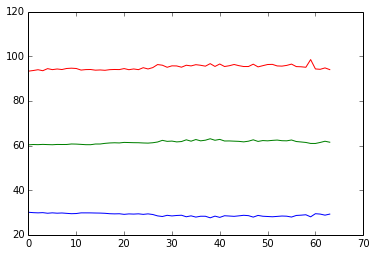

In [8]:
voltagediff = baselines[0,:,:,:] / slopes

#plot ( (before correction) - baseline )/m
plot(times[:],(subtractions[1,200,0,:]/avgslopes[200,0,:]))
plot(times[:],(subtractions[2,200,0,:]/avgslopes[200,0,:]))
plot(times[:],(subtractions[3,200,0,:]/avgslopes[200,0,:]))

ylim(20,120)
# ylabel('ADC counts')
# xlabel('Samples')
show()

(-5, 7)

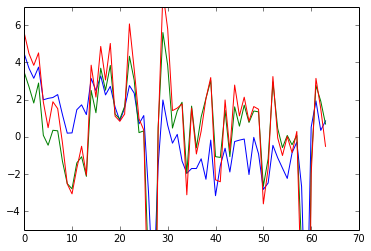

In [9]:
#plot the relative difference to the mean for each data point
#for (before correction) - baseline
for i in range(1,nvpeds):
    avg1 = np.average(subtractions[i,200,0,:])
    reldiff1 = (subtractions[i,200,0,:] - avg1)
    plot(times[:], reldiff1)
    
ylim(-5,7)


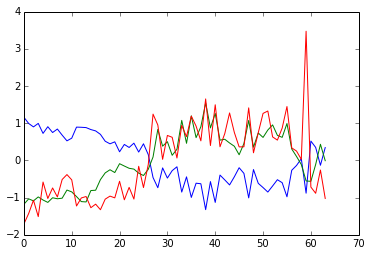

In [10]:
#plot the relative difference to the mean for each data point
#for ( (before correction) - baseline)/m
for i in range(1,nvpeds):
    avg2 = np.average(subtractions[i,200,0,:]/avgslopes[200,0,:])
    reldiff2 = (subtractions[i,200,0,:]/avgslopes[200,0,:] - avg2)
    plot(times[:], reldiff2)

In [15]:
run2 = 307940
pulsein = "sampleFileLarge_run{}ASIC{}CH{}.txt".format(run2,asic,channel)
dat = np.loadtxt(pulsein)
print dat.shape

#to store regular pedestal data
pedData = np.zeros((dat.shape[0],64))
#to store calibrated pedestal data
calData = np.zeros((dat.shape[0],64))
#to store block and shift information
blockIP = np.zeros((pedData.shape[0],2))

#for all events
for i in range(dat.shape[0]):
    #this is picking out the first 25 samples and subtracting the Vped baseline from them
    avg = dat[i,5:30] - baselines[0,dat[i,3],dat[i,4],0:25]
    #taking pulse data and subtracting both the baseline and the avg of the first 25 samples above the baseline
    pedData[i] = dat[i,5:] - baselines[0,dat[i,3],dat[i,4]] - avg.mean()
    #taking pedData[i] / the slope correction
    calData[i] = (dat[i,5:] - baselines[0,dat[i,3],dat[i,4]] - avg.mean() )/avgslopes[dat[i,3],dat[i,4],:]
    #documenting block and shift
    blockIP[i,0] = int(dat[i,3])
    blockIP[i,1] = int(dat[i,4])
            
print pedData.shape[0]

    

(199980, 69)
199980


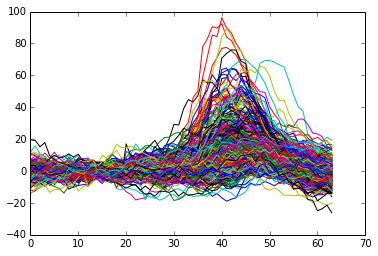

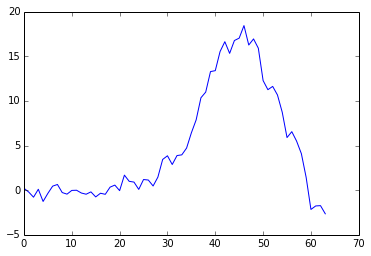

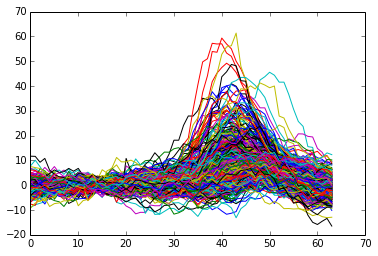

In [17]:
#Just produce some plots:
average=np.zeros(64)
count=0
for i in range(pedData.shape[0]):
    if(blockIP[i,0]==200):
        plot(times, pedData[i])
        if(blockIP[i,1]==0):
            average+=pedData[i]
            count+=1
show()

plot(times, average/count)
show()


for i in range(pedData.shape[0]):
    if(blockIP[i,0]==200):
        plot(times, calData[i])
        
show()

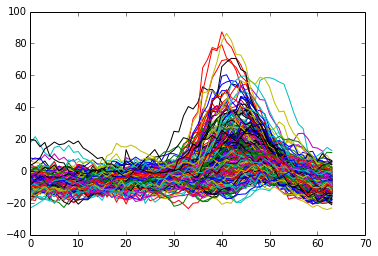

In [147]:
for i in range(pulsedata.shape[0]):
    if(pulsedata[i,3]==200 and pulsedata[i,4]<4 ):
        plot(times, pulsedata[i,5:] - baselines[0,pulsedata[i,3],pulsedata[i,4],:])

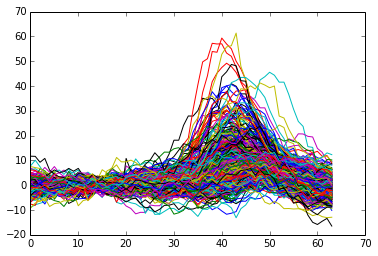

In [151]:
calibratedPulse = np.zeros(((pulsedata.shape[0],66)))
for i in range(pulsedata.shape[0]):
    calibratedPulse[i][0] = pulsedata[i,3]
    calibratedPulse[i][1] = pulsedata[i,4]
    calibratedPulse[i][2:] = (pulsedata[i,5:]-np.average(pulsedata[i,5:30]-baselines[0,pulsedata[i,3],pulsedata[i,4],:25]) - baselines[0,pulsedata[i,3],pulsedata[i,4],:]) / avgslopes[pulsedata[i,3],pulsedata[i,4],:]
    if(pulsedata[i,3]==200 and pulsedata[i,4]<4):
        #print i
        plot(times, (pulsedata[i,5:]-np.average(pulsedata[i,5:30]-baselines[0,pulsedata[i,3],pulsedata[i,4],:25]) - baselines[0,pulsedata[i,3],pulsedata[i,4],:]) / avgslopes[pulsedata[i,3],pulsedata[i,4],:])
#print avgslopes[pulsedata[5282,3],pulsedata[5282,4],:]

In [18]:
#This can be used to calculate the charge
def getCharge(data,inter):
    maximum = data[5:60].argmax() + 5
    integral=0
    for i in range(inter):
        integral+=data[maximum-inter/2+i]
    #Maxval is only used for comparison. It might give us a peak spectrum as well.
    maxVal = data[5:60].max()
    
    return integral/inter, maxVal

In [19]:
charge=[]
calCharge=[]
maxVal=[]
maxCalVal=[]

charge2=[]
calCharge2=[]
maxVal2=[]
maxCalVal2=[]

for i in range(pedData.shape[0]):
    if(blockIP[i,0]==100 and blockIP[i,1]<4):
        charge.append( getCharge(pedData[i], 10)[0] )
        calCharge.append( getCharge(calData[i], 10)[0] )
        maxCalVal.append( getCharge(calData[i], 10)[1] )
        maxVal.append( getCharge(pedData[i], 10)[1] )

    if(blockIP[i,0]==201 and blockIP[i,1]<4):
        charge2.append( getCharge(pedData[i], 10)[0]*7.0/6.0 )
        calCharge2.append( getCharge(calData[i], 10)[0]*7.0/6.0 )
        maxCalVal2.append( getCharge(calData[i], 10)[1] )
        maxVal2.append( getCharge(pedData[i], 10)[1] )

        
charge = np.array(charge)
calCharge = np.array(calCharge)
maxVal = np.array(maxVal)
maxCalVal = np.array(maxCalVal)

charge2 = np.array(charge2)
calCharge2 = np.array(calCharge2)
maxVal2 = np.array(maxVal2)
maxCalVal2 = np.array(maxCalVal2)


print charge.shape

(388,)


(0.0, 70.0)


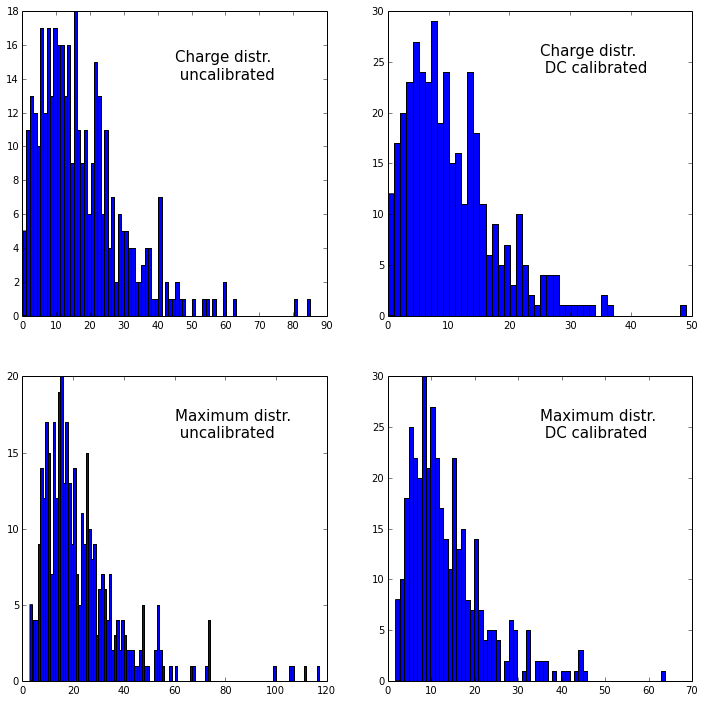

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,12))


binsize=1
ax[0,0].hist(charge, bins=np.arange(charge.min(), charge.max()-10,binsize))
#ax[0,0].hist(charge2, bins=np.arange(charge.min(), charge.max()-10,binsize), alpha=0.5)
ax[0,0].annotate("Charge distr. \n uncalibrated", xy=(int(ax[0,0].get_xlim()[1]*0.5),int(ax[0,0].get_ylim()[1]*0.8)), fontsize=15)
ax[0,1].hist(calCharge, bins=np.arange(calCharge.min(), calCharge.max()-10,binsize))
#ax[0,1].hist(calCharge2, bins=np.arange(calCharge.min(), calCharge.max()-10,binsize), alpha=0.5)
ax[0,1].annotate("Charge distr. \n DC calibrated", xy=(int(ax[0,1].get_xlim()[1]*0.5),int(ax[0,1].get_ylim()[1]*0.8)), fontsize=15)
ax[1,0].hist(maxVal, bins=np.arange(maxVal.min(), maxVal.max()-10,binsize))
#ax[1,0].hist(maxVal2, bins=np.arange(maxVal.min(), maxVal.max()-10,binsize), alpha=0.5)
ax[1,0].annotate("Maximum distr. \n uncalibrated", xy=(int(ax[1,0].get_xlim()[1]*0.5),int(ax[1,0].get_ylim()[1]*0.8)), fontsize=15)
ax[1,1].hist(maxCalVal, bins=np.arange(maxCalVal.min(), maxCalVal.max()-10,binsize))
#ax[1,1].hist(maxCalVal2, bins=np.arange(maxCalVal.min(), maxCalVal.max()-10,binsize), alpha=0.5)
ax[1,1].annotate("Maximum distr. \n DC calibrated", xy=(int(ax[1,1].get_xlim()[1]*0.5),int(ax[1,1].get_ylim()[1]*0.8)), fontsize=15)

print ax[1,1].get_xlim()

show()

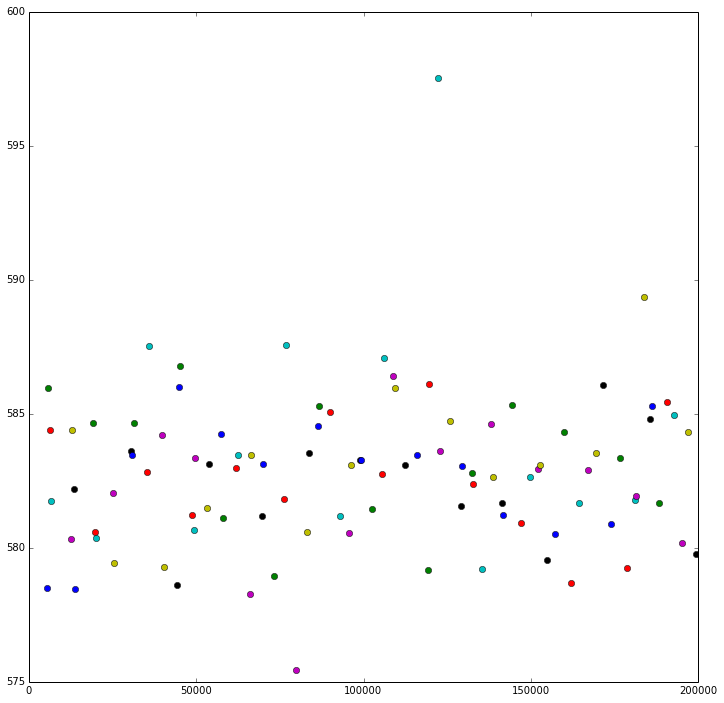

In [135]:
event1 = np.arange(0,pulsedata.shape[0],1)
avgpulse = np.zeros((pulsedata.shape[0],3))
for base in range(pulsedata.shape[0]):
    avgpulse[base,0] = pulsedata[base,3]
    avgpulse[base,1] = pulsedata[base,4]
    avgpulse[base,2] = np.average(pulsedata[base,5:30])
    
pulsespread=[]

fig = plt.figure(figsize=(12,12))
for i in range(avgpulse.shape[0]):
        #
    if( int(avgpulse[i,0])==200 and int(avgpulse[i,1])==0):
        #print average0[i]
        plot(event1[i],avgpulse[i,2], marker="o")
        pulsespread.append(avgpulse[i])

In [97]:
baseline0in = "sampleFileLarge_run307936ASIC0CH7.txt"
baseline0 = np.loadtxt(baseline0in)

print baseline0.shape

(199980, 69)


In [131]:
event = np.arange(0,baseline0.shape[0],1)
average0 = np.zeros((baseline0.shape[0],3))
for base in range(baseline0.shape[0]):
    average0[base,0] = baseline0[base,3]
    average0[base,1] = baseline0[base,4]
    average0[base,2] = np.average(baseline0[base,5:30])



(199980,)
(199980, 3)


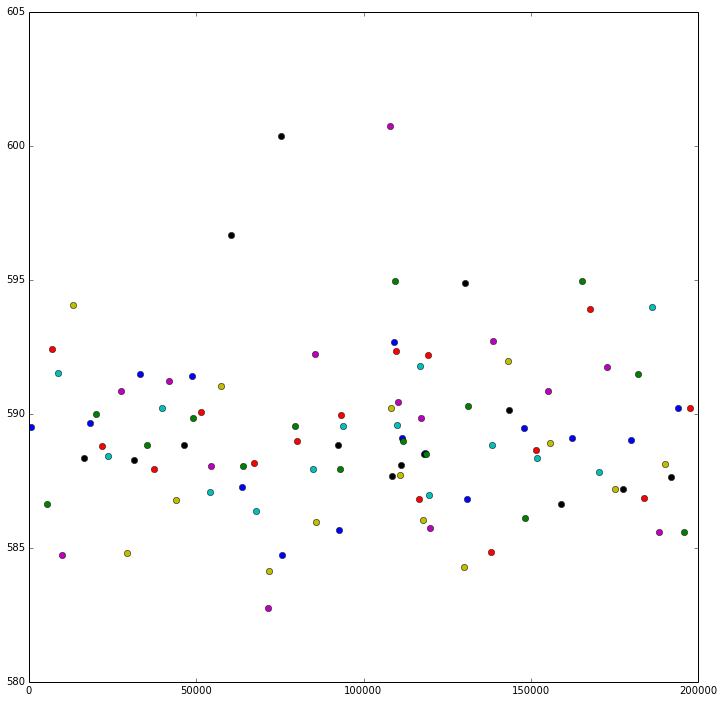

In [132]:
print event.shape
print average0.shape

spread=[]

fig = plt.figure(figsize=(12,12))
for i in range(average0.shape[0]):
        #
    if( int(average0[i,0])==200 and int(average0[i,1])==0):
        #print average0[i]
        plot(event[i],average0[i,2], marker="o")
        spread.append(average0[i])

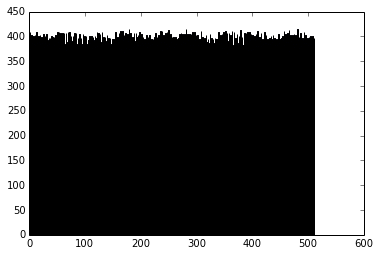

In [133]:
plt.hist(average0[:,0], bins=512)

plt.show()

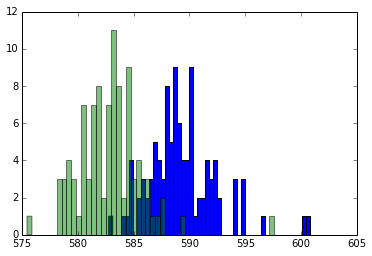

In [140]:
spread=np.array(spread)
pulsespread=np.array(pulsespread)
plt.hist(spread[:,2], bins=50)
plt.hist(pulsespread[:,2], bins=50,alpha=0.5)
plt.show()